In [12]:
import random
import os
import pandas as pd
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread

In [49]:
#First load the data
train_images = sorted(os.listdir('/kaggle/input/image-classification-real-or-ai-generated-photo/train/train'), key=lambda x: int(os.path.splitext(x)[0]))
test_images = sorted(os.listdir('/kaggle/input/image-classification-real-or-ai-generated-photo/test/test'), key=lambda x: int(os.path.splitext(x)[0]))

train_labels = pd.read_csv('/kaggle/input/image-classification-real-or-ai-generated-photo/train.csv')
test_labels = pd.read_csv('/kaggle/input/image-classification-real-or-ai-generated-photo/test.csv')

#Make sure that labels correctly match with each image when you work with the dataset

In [3]:
root_dir="/kaggle/input/ai-generated-images-vs-real-images"

In [2]:
train_images_real = os.listdir('/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt')
train_images_real = [os.path.join(r'RealArt/RealArt',x) for x in train_images_real]
train_images_fake= os.listdir('/kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData')
train_images_fake = [os.path.join(r'AiArtData/AiArtData',x) for x in train_images_fake]


In [4]:
train_labels_fake = pd.DataFrame({'Image':train_images_fake,'Label':0})
train_labels_real = pd.DataFrame({'Image':train_images_real,'Label':1})
train_labels2 = pd.concat([train_labels_fake,train_labels_real],axis=0, ignore_index=True)


In [33]:
train_labels2=train_labels2.sample(frac = 1)

In [13]:
train_labels2

,Image,Label
0,AiArtData/AiArtData/Various-AI-portraits-gener...,0
1,AiArtData/AiArtData/images77.jpg,0
2,AiArtData/AiArtData/1000_F_563719058_JXnzcPV4G...,0
3,AiArtData/AiArtData/MidJourney-content-policy-...,0
4,AiArtData/AiArtData/an-ai-jungle-landscape-mad...,0
...,...,...
970,RealArt/RealArt/fw-fox-squirrel.jpg,1
971,RealArt/RealArt/large-beautiful-print-of-villa...,1
972,RealArt/RealArt/360_F_380747975_sS1hCVB0qPqFCW...,1
973,RealArt/RealArt/pexels-photo-5091121.jpeg,1


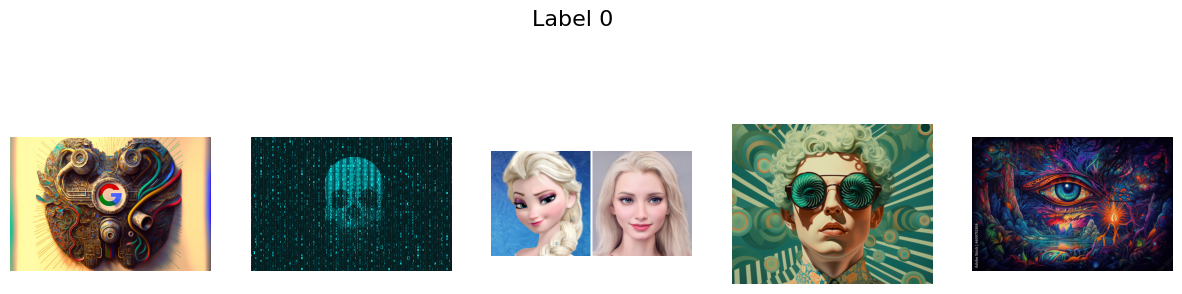

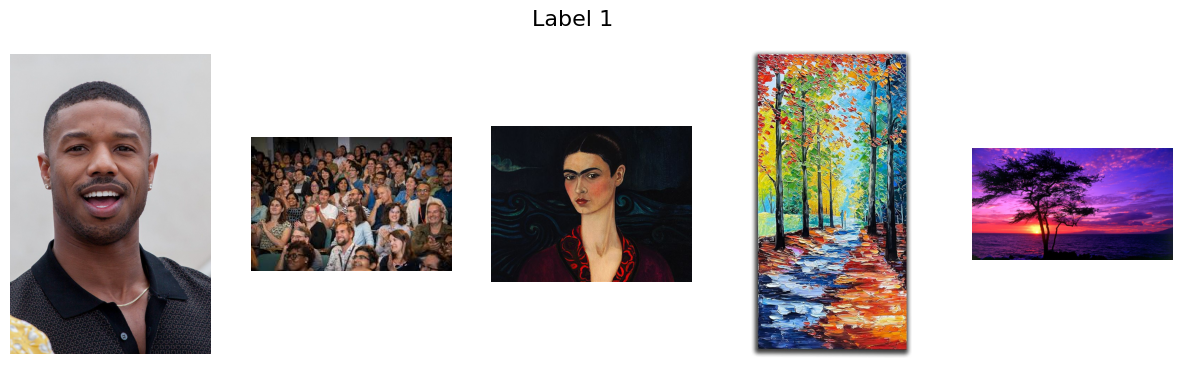

In [71]:
# Display some train images and their labels
# Remember 0 is ai-generated and 1 is authentic
def display_random_images(train_labels, num_images=5):
    for label in [0, 1]:
        filtered_train = train_labels[train_labels['Label'] == label]

        # Sample '5 random rows from the filtered dataframe
        sample_images = filtered_train.sample(n=num_images)

        fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
        fig.suptitle(f'Label {label}', fontsize=16)

        # Display each sampled image
        for ax, (_, row) in zip(axes, sample_images.iterrows()):
            image_path = os.path.join(root_dir, row['Image'])
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis('off')

        plt.show()

# Display 5 authentic and 5 ai-generated images. 0 = ai-generated, 1 = authentic
display_random_images(train_labels2, num_images=5)

Now we will display some of the images from the test set. Note that you do not have any labels in the test set so for now we will also show you the images. The task is for you to generate the labels for the test set.

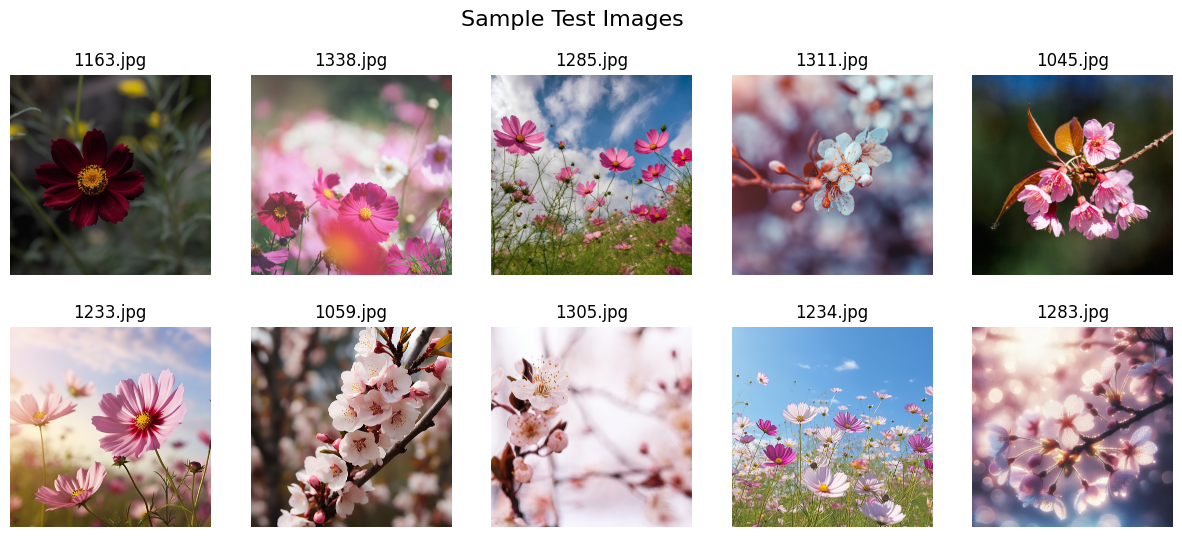

In [4]:
sample_images_test = random.sample(test_images, 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Test Images', fontsize=16)

# Display each sampled test image
for ax, filename in zip(axes.flatten(), sample_images_test):
    image_path = os.path.join('/kaggle/input/image-classification-real-or-ai-generated-photo/test/test', filename)
    try:
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(filename)
    except Exception as e:
        print(f"Error opening {image_path}: {e}")
        ax.set_title('Error loading image')
        ax.axis('off')

plt.show()

Great! Now we will make predictions for the test set. You are to predict 0 for ai-generated photos and 1 for authentic photos.

Here, we will use a random generator as our model. Feel free to create an interesting and more fancy model for your submission.

Below, we will only generate a sample_submission file that will show you the format we expect your solution to be in.

Your submission should be a csv file with two columns.

*   Image : the name of the test photo
*   Label : your prediction for the test photo



In [34]:
# import the necessary packages
!pip install imutils
!pip install wget
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dropout,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import wget
import cv2
from PIL import Image



In [73]:
!pip install -U -q imgaug --user


In [35]:
from imgaug import augmenters as iaa
import imgaug as ia
ia.seed(42)
rand_aug = iaa.RandAugment(n=3, m=13)

def augment_single(image):

    # Convert to float32 and scale to [0, 1]
    image_np = (image).astype(np.uint8)

    # Apply RandAugment transformation to the single image
    augmented_image = rand_aug(image=image_np)


    return augmented_image/255

In [52]:
datagen = ImageDataGenerator(
    fill_mode='nearest',
    validation_split=0.2,
    # Perspective transformation (randomly applied with a probability of 0.35)
     preprocessing_function=(
        lambda x:augment_single(x)
    )
   
)

In [53]:
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 32
desired_size=(HEIGHT,WIDTH)

In [54]:
'''train_labels['Label'] = train_labels['Label'].astype(str)
'''
train_labels2['Label'] = train_labels2['Label'].astype(str)


In [55]:
train_generator=datagen.flow_from_dataframe(
  dataframe=train_labels2,
  directory=root_dir,
  x_col='Image',
  y_col='Label',
  subset="training",
  batch_size=32,
  seed=42,
  color_mode='rgb',
  shuffle=True,
  class_mode='binary',
  target_size=(HEIGHT,WIDTH))
valid_generator=datagen.flow_from_dataframe(
  dataframe=train_labels2,
  directory=root_dir,
  x_col='Image',
  y_col='Label',
  subset="validation",
  batch_size=32,
  seed=42,
  color_mode='rgb',
  shuffle=True,
  class_mode='binary',
  target_size=(HEIGHT,WIDTH))


Found 776 validated image filenames belonging to 2 classes.
Found 194 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 5 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 5 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


In [40]:
np.bool = bool


In [12]:

baseModel = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(WIDTH, HEIGHT, 3)))


# the base model
headModel = baseModel.output

headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(1, activation="sigmoid")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)


# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


print("[INFO] compiling model...")

model.compile(loss="binary_crossentropy", optimizer='Adam',metrics=["accuracy"])




83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
[INFO] compiling model...


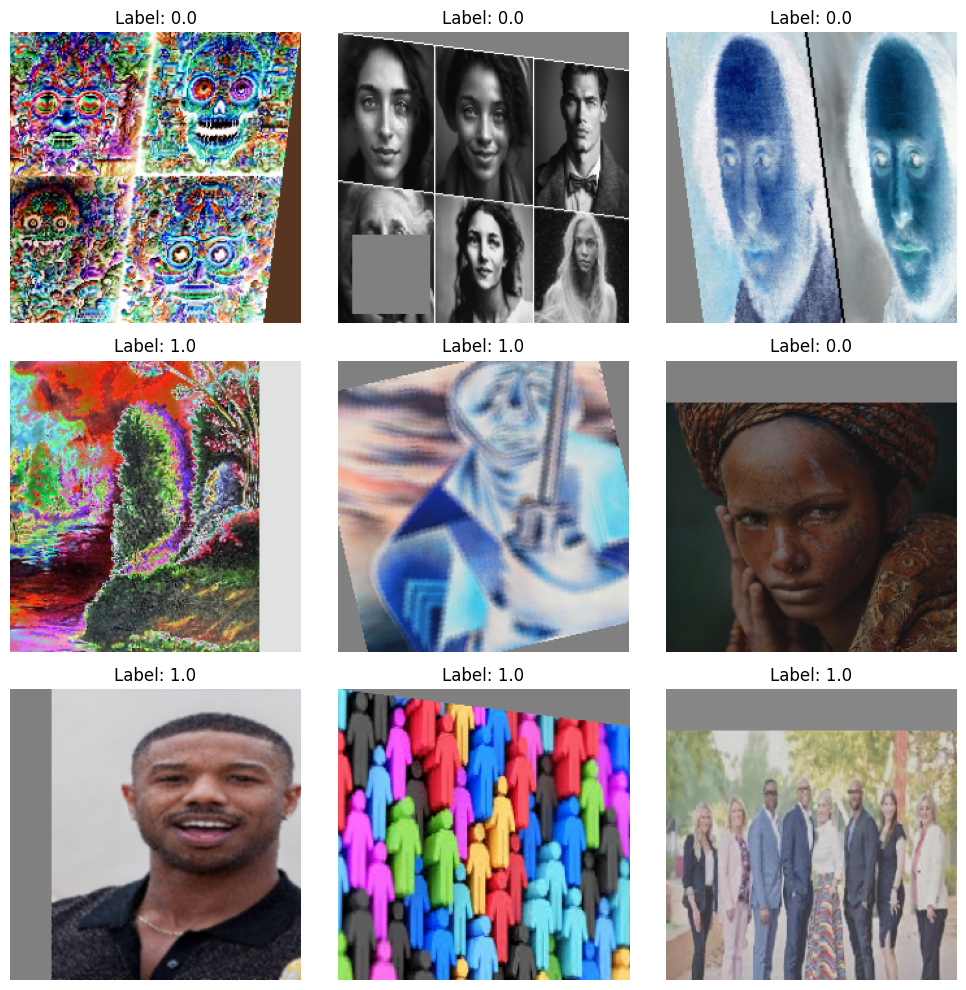

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the train_generator
images, labels = next(train_generator)

# Number of images to display
num_images = 9  # For example, display 9 images

# Create a plot with subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop through the images and labels to display them
for i, ax in enumerate(axes.flat):
    if i < num_images:
        # Get the image and label for the current index
        img = images[i]
        label = labels[i]
        
        # Display the image
        ax.imshow(img)
        ax.axis('off')  # Hide axis
        
        # Show the label (for binary classification, labels are 0 or 1)
        ax.set_title(f'Label: {label}')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [56]:
import tensorflow
model=tensorflow.keras.models.load_model(r'/kaggle/input/xception-for-ai-generated-images-detection/tensorflow2/default/2/best_model.h5')
model.compile(loss="binary_crossentropy", optimizer='Adam',metrics=["accuracy"])


In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint
# this is for best fit methode, only best validation accuracy weights will be loaded
checkpoint_callback = ModelCheckpoint(filepath='best_model2.h5.keras',
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1)

In [58]:
EPOCHS=20
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
H1 = model.fit(
    train_generator,                          # Directly passing the generator as the first argument
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
W0000 00:00:1731609967.958937     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15/24 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4678 - loss: 2.2254  

W0000 00:00:1731609988.771293     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4628 - loss: 1.7892

W0000 00:00:1731609997.446287     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.46875, saving model to best_model2.h5.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4621 - loss: 1.7575 - val_accuracy: 0.4688 - val_loss: 0.6948
Epoch 2/20
 1/24 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - accuracy: 0.4062 - loss: 0.6987

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.46875
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4062 - loss: 0.6987 - val_accuracy: 0.0000e+00 - val_loss: 0.7145
Epoch 3/20


W0000 00:00:1731610004.411659     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.4318 - loss: 0.6955
Epoch 3: val_accuracy did not improve from 0.46875
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 844ms/step - accuracy: 0.4323 - loss: 0.6955 - val_accuracy: 0.4583 - val_loss: 0.6934
Epoch 4/20
 1/24 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.5312 - loss: 0.6935
Epoch 4: val_accuracy improved from 0.46875 to 1.00000, saving model to best_model2.h5.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5312 - loss: 0.6935 - val_accuracy: 1.0000 - val_loss: 0.6904
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.4714 - loss: 0.6933
Epoch 5: val_accuracy did not improve from 1.00000
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 863ms/step - accuracy: 0.4736 - loss: 0.6933 - val_accuracy: 0.5365 - val_loss: 0.6927
Epoch 6/20
 1/24 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.6250 - loss: 0.6914
Epoch 6: val_accuracy did not improve from 1.00000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.6

In [48]:
model2=tensorflow.keras.models.load_model(r'/kaggle/working/best_model2.h5.keras')

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os
def predict_label(test_data, model):
    predictions = []
    
    for img_path in test_data:
        # Load and preprocess the image from the given path
        img = image.load_img(os.path.join(r'/kaggle/input/image-classification-real-or-ai-generated-photo/test/test',img_path), target_size=(224, 224))  # Adjust size as needed
        img_array = image.img_to_array(img) / 255.0  # Normalize image to [0, 1] range
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Predict the label using the model
        pred = model.predict(img_array)  # This will output probabilities for binary classification
        
        # Convert prediction to binary label (0 or 1)
        binary_label = 1 if pred > 0.5 else 0
        predictions.append(binary_label)
    
    return predictions

# Assuming 'test_images' contains the file paths of the images
test_images_paths = test_labels['Image'].tolist()  # Extract image paths from the 'Image' column
predictions = predict_label(test_images_paths, model)



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

In [ ]:
predictions

In [28]:
'''def predict_label(test_data):
  return [random.choice([0, 1]) for _ in range(len(test_data))]

predictions = predict_label(test_images)'''
sample_submission = pd.DataFrame({'Image': [img for img in test_images], 'Label': predictions})

In [29]:
sample_submission.to_csv('sample_submission.csv', index=False)

And with this you have a sample_submission.csv file that you can upload to Kaggle.

**How to Upload to Kagagle**

The instructions below were borrowed from HW5 for the Machine Learning Autumn 2023 course at the University of Tartu.

You can either use Kaggle API below to submit submission file or download file and submit it manually to Kaggle via web interface.

You need to have an account on Kaggle.com, before you proceed. When you access your kaggle profile, you need to download your API Token from kaggle. It's very easy:

Click on your profile icon
Go to Account
In API you press Create new API token
Now we load the file kaggle.json that you have downloaded, into this notebook:

In [ ]:
files.upload(); # upload your kaggle.json file

The next cell moves the file into a separate folder, sets secure access for it and configures your Kaggle profile for this notebook.

In [ ]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

Assuming that you have accepted the rules of the competition, you should be able to make a submission using the following code:

In [ ]:
!kaggle competitions submit -c image-classification-real-or-ai-generated-photo -f sample_submission.csv -m "Random submission"

In [ ]:
model.load(r'')

# Example of making predictions for a single image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(WIDTH, HEIGHT))
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize if required (based on your training preprocessing)

    prediction = model.predict(img_array)  # Get model prediction
    return prediction

# Example usage: Make a prediction on a test image
img_path = 'path_to_test_image.jpg'
predicted_class = predict_image(img_path)
print("Predicted class:", predicted_class)


In [30]:
model.save(r'/kaggle/working/best_model.h5')